# Resampling Data

I do change the spectral resolution change the width of channels, for equalize the resolution with the Yoko's cube, at 1 $\frac{km}{s}$.


___spectral-cube__ is the primary radio-astro-tools package that enables fast and flexible I/O operations with most common analysis methods backed by the astropy ecosystem (https://science.nrao.edu/facilities/alma/science_sustainability/Spectral_Cube_and_Radio_Beam_Ginsburg.pdf). Spectral-cube has several tools to enable reprojection of cubes onto different spatial and spectral grids (https://spectral-cube.readthedocs.io/en/latest/reprojection.html#spectral-reprojection). Prior to reprojecting data, in order to minimize resampling artifacts, it is a good idea to smooth the data first. A worked example of spatial and spectral smoothing is given on the reprojection tutorial.




The __spectral_interpolate()__ function allows interpolation of the data onto a new spectral grid.The expected input is a list of pixel coordinates. This function, dont reduce the signal to noise, and can amplify it if the spectrum has many small variations (high frequency noise). To avoid introducing noise, a spectral cube smoothing is performed with a Gaussian kernel to adapt to the new channel width. To perform this smoothing, the following is used __spectral_smooth()__ (https://spectral-cube.readthedocs.io/en/latest/smoothing.html#spectral-smoothing).



In [2]:
### Import necessary libraries


from spectral_cube import SpectralCube
from astropy import units as u
from astropy.convolution import Gaussian1DKernel
import numpy as np

The Gaussian kernel is a function used to represent the distance between a set of neighboring points from a central point by assigning higher weights to the closer points and lesser weights to the distant points. This function relates closely to the Gaussian distribution in the sense that the points which ultimately make up the matrix are calculated on the basis of Gaussian distribution.

Mathematical representation
$$K(x, y) = (\frac{1}{2 * \pi * \sigma^2}) * exp(-\frac{(x^2 + y^2)}{(2 * \sigma^2)})$$

In [3]:
### Charge the cube
#cube = SpectralCube.read('RESULTS\FITS\cube_with_vel.fits')
cube = SpectralCube.read('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/FILES/member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits')
cube2 = SpectralCube.read('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/FILES/N159_CII_map.fits')  # YOKO'S cube
# Open header
header = cube.header
header2 = cube2.header
print(header)

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    3                                                  NAXIS1  =                  120                                                  NAXIS2  =                  128                                                  NAXIS3  =                 2043                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   4.442253420057E-03                                                  BMIN    =   3.226777089219E-03                                                  BPA     =  -8.550686982140E+01                                                  BTYPE   = 'Intensity'                   

In [4]:
# check the actual spectral resolution
print(cube.header['CDELT3'])
print(cube2.header['CDELT3'])

122083.4000092
1.0


In [5]:
restfreq = cube.header['RESTFRQ']
print(restfreq)


102587476000.0


In [6]:
FREQ_axis = cube.spectral_axis
print(FREQ_axis)

[1.02382477e+11 1.02382599e+11 1.02382721e+11 ... 1.02631527e+11
 1.02631649e+11 1.02631771e+11] Hz


In [7]:
## change the unit of the spectral axis to GHz
cubevel = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restfreq * u.Hz)
print(cubevel.spectral_axis)

[ 599.07055662  598.71379102  598.35702542 ... -128.7312702  -129.08803581
 -129.44480141] km / s


In [8]:
current_resolution = np.abs(cubevel.spectral_axis[1] - cubevel.spectral_axis[0]) # resolucion espectral actual del cubp
print(current_resolution)

0.3567656013855185 km / s


In [9]:
px_scale = cubevel.header['CRPIX3'] 
print(px_scale)  # this is the pixel coordineate of reference point 

1.0


In [10]:
# Apply the smoothing for cumplir el requerimiento de Nyquist !!! 
fwhm = np.sqrt(8 * np.log(2))
target_resolution = cube2.header['CDELT3'] * u.km/u.s  # Resolucion espectral deseada

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /(current_resolution * fwhm)) ## Calculo de un ancho estamdar (sigma) de un kernel gaussiano que se usara para suavizar el eje espectral y alcanzar una resolucion espectral deseada.
## Using CDELT3 as a reference pixel scale

#gaussian_width = (np.sqrt(target_resolution**2 - current_resolution**2) )

print(gaussian_width)

kernel = Gaussian1DKernel(gaussian_width.value) 

1.1119783836561525


In [11]:
smooth_cube = cubevel.spectral_smooth(kernel)
#print(smooth_cube.spectral_axis)

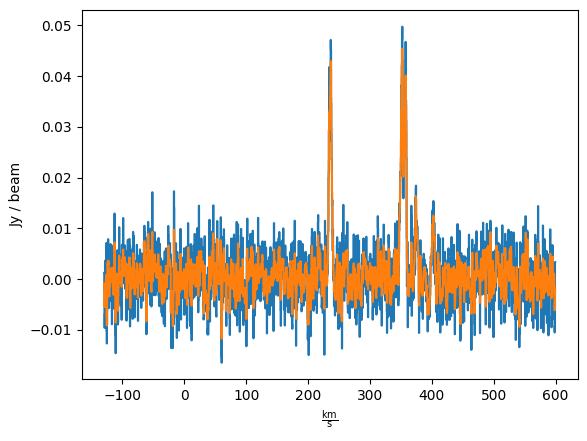

In [12]:
y, x = 73, 63

spec = cubevel[:, y, x]
spec2 = smooth_cube[:, y, x]
spec.quicklook()
spec2.quicklook()


In [47]:
# apply the interpolation

v_min = np.floor(cubevel.spectral_axis.min()  )
v_max = np.ceil(cubevel.spectral_axis.max() )
new_axis_v = np.arange(v_min.value + 1 , v_max.value, target_resolution.value)  * u.km/u.s
print(new_axis_v)


#v_min = np.floor(cubevel.spectral_axis.min()  )
#v_max = np.ceil(cubevel.spectral_axis.max() )
#new_axis_v = np.arange(v_min.value + 1 , v_max.value - 1 + target_resolution.value, target_resolution.value)  * u.km/u.s

#resampled_cube = cubevel.spectral_interpolate(new_axis_v, suppress_smooth_warning=True)


[-129. -128. -127. -126. -125. -124. -123. -122. -121. -120. -119. -118.
 -117. -116. -115. -114. -113. -112. -111. -110. -109. -108. -107. -106.
 -105. -104. -103. -102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.
  -93.  -92.  -91.  -90.  -89.  -88.  -87.  -86.  -85.  -84.  -83.  -82.
  -81.  -80.  -79.  -78.  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.
  -69.  -68.  -67.  -66.  -65.  -64.  -63.  -62.  -61.  -60.  -59.  -58.
  -57.  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -49.  -48.  -47.  -46.
  -45.  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.  -34.
  -33.  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.
  -21.  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.
   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.    1.    2.
    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   

In [48]:
resampled_cube = smooth_cube.spectral_interpolate(new_axis_v, suppress_smooth_warning=True)


Spectral Interpolate:   0%|          | 0/15360 [00:00<?, ?it/s]

In [49]:
print(resampled_cube.spectral_axis)

[-129. -128. -127. -126. -125. -124. -123. -122. -121. -120. -119. -118.
 -117. -116. -115. -114. -113. -112. -111. -110. -109. -108. -107. -106.
 -105. -104. -103. -102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.
  -93.  -92.  -91.  -90.  -89.  -88.  -87.  -86.  -85.  -84.  -83.  -82.
  -81.  -80.  -79.  -78.  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.
  -69.  -68.  -67.  -66.  -65.  -64.  -63.  -62.  -61.  -60.  -59.  -58.
  -57.  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -49.  -48.  -47.  -46.
  -45.  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.  -34.
  -33.  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.
  -21.  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.
   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.    1.    2.
    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   

In [50]:
Invert_resampled_cube = resampled_cube[::-1, :, :]  # Invert the cube
print(Invert_resampled_cube.spectral_axis)

[ 599.  598.  597.  596.  595.  594.  593.  592.  591.  590.  589.  588.
  587.  586.  585.  584.  583.  582.  581.  580.  579.  578.  577.  576.
  575.  574.  573.  572.  571.  570.  569.  568.  567.  566.  565.  564.
  563.  562.  561.  560.  559.  558.  557.  556.  555.  554.  553.  552.
  551.  550.  549.  548.  547.  546.  545.  544.  543.  542.  541.  540.
  539.  538.  537.  536.  535.  534.  533.  532.  531.  530.  529.  528.
  527.  526.  525.  524.  523.  522.  521.  520.  519.  518.  517.  516.
  515.  514.  513.  512.  511.  510.  509.  508.  507.  506.  505.  504.
  503.  502.  501.  500.  499.  498.  497.  496.  495.  494.  493.  492.
  491.  490.  489.  488.  487.  486.  485.  484.  483.  482.  481.  480.
  479.  478.  477.  476.  475.  474.  473.  472.  471.  470.  469.  468.
  467.  466.  465.  464.  463.  462.  461.  460.  459.  458.  457.  456.
  455.  454.  453.  452.  451.  450.  449.  448.  447.  446.  445.  444.
  443.  442.  441.  440.  439.  438.  437.  436.  4

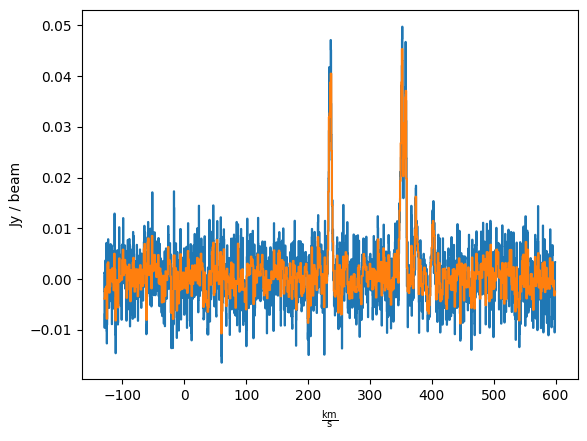

In [51]:
y, x = 73, 63

spec = cubevel[:, y, x]
spec2 = Invert_resampled_cube[:, y, x]
spec.quicklook()
spec2.quicklook()

In [ ]:
mean1 = cubevel.mean().value       # Media
median1 = cubevel.median().value   # Mediana
std1 = cubevel.std().value         # Desviación estándar (RMS)
max_val1 = cubevel.max().value     # Valor máximo
min_val1 = cubevel.min().value     # Valor mínimo

print(f'Media: {mean1}')
print(f'Mediana: {median1}')
print(f'Desviación estándar: {std1}')
print(f'Valor máximo: {max_val1}')
print(f'Valor mínimo: {min_val1}')


Media: -4.8437659643241204e-06
Mediana: -3.3620647172938334e-06
Desviación estándar: 0.012278317473828793
Valor máximo: 0.11928344517946243
Valor mínimo: -0.11385370045900345


In [45]:
mean2 = Invert_resampled_cube.mean().value       # Media
median2 = Invert_resampled_cube.median().value   # Mediana
std2 = Invert_resampled_cube.std().value         # Desviación estándar (RMS)
max_val2 = Invert_resampled_cube.max().value     # Valor máximo
min_val2 = Invert_resampled_cube.min().value     # Valor mínimo

print(f'Media: {mean2}')
print(f'Mediana: {median2}')
print(f'Desviación estándar: {std2}')
print(f'Valor máximo: {max_val2}')
print(f'Valor mínimo: {min_val2}')

Media: -5.0350686247990595e-06
Mediana: -8.529061517623799e-06
Desviación estándar: 0.007657009224804801
Valor máximo: 0.0708968953760184
Valor mínimo: -0.07077625137509995


In [ ]:
#resampled_cube.write('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/resampled_cube_Yokospect.fits') # Using the YOKO Spectral data cube to resampling
#resampled_cube.write('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/resampled_cube.fits') # No using the YOKO Spectral data cube to resamplin 
#resampled_cube.write('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/resampled_cube1.fits') # No using the YOKO Spectral data cube to resamplin and no using smooth

Invert_resampled_cube.write('C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/resampled_cube_invert.fits') # No using the YOKO Spectral data cube to resamplin and no using smooth